#Data Science London + Scikit-learn

Kaggle用于[学习Sklearn的比赛](https://www.kaggle.com/c/data-science-london-scikit-learn/data)。 

## 数据 
1. train.csv 1000 x 40 
2. test.csv 9000 x 40
3. trainLabels.csv 1000x 1

Train set中有1000个样本，测试样本9000个样本。



In [0]:
# Pull and unzip data from VPS

!wget bwg.fayderlau.xyz:81/datascience.zip && unzip datascience.zip  
# simplify directory name 
!mv data-science-london-scikit-learn data 
!ls

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv('data/train.csv', header=None)
test = pd.read_csv('data/test.csv', header=None)

# Flatten labels, unlike np.flatten, which returns a copy of matrix, np.ravel 
# returns a view, lick reference of C/C++, of original matrix
labels = np.ravel(pd.read_csv('data/trainLabels.csv', header=None))



## 先考虑只使用KNN 且不使用特征缩放
先不使用 Feature Scaling 

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

xtrain, xtest, ytrain, ytest = train_test_split(train, labels, test_size=0.3, random_state=714)
xtrain.shape

###使用网格搜索寻找最优参数

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':list(range(1, 25))}
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid = param_grid, cv=5, n_jobs=-1)
grid.fit(xtrain, ytrain)
print("Best cv accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(xtest, ytest)))
print("Best parameters: ", grid.best_params_)

# Predict test with best KNN 
# 1st sub: Best_param: {'n_neighbors': 5}, submission result: 0.87444 
# 2nd sub: Best_param: {'n_neighbors': 6}, submission result: 0.87593

def make_submission(estimator):
  test_fill = np.nan_to_num(test)
  result = pd.DataFrame(estimator.predict(test_fill))
  print(result.shape)
  result.columns = ['Solution']
  result['Id'] = np.arange(1, result.shape[0] +1)
  result = result[['Id', 'Solution']]
  result.to_csv('submission.csv', index=False)

###手动寻找最优参数
不使用于网格搜索

结论：效果比使用Grid Search稍微好一点，最佳结果 0.87593 (Grid Search) V.S. 0.87630

In [0]:
neighbors = np.arange(1,26)
train_accuracy = []
val_accuracy = []
kfold, best_knn, best_acc = 10, None, 0

for i, k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
  knn.fit(xtrain, ytrain)
  train_accuracy.append(knn.score(xtrain, ytrain))
  cur_acc = np.mean(cross_val_score(knn, train, labels, cv=kfold))
  val_accuracy.append(cur_acc)
  
  if cur_acc > best_acc:
    best_knn = knn
    best_acc = cur_acc

plt.figure(figsize=[13, 8])
plt.plot(neighbors, val_accuracy, label="Validation Accuracy")
plt.plot(neighbors, train_accuracy, label="Training Accuracy")
plt.legend()

print('Best Accuracy without feature scaling:', best_acc)
print(best_knn)  

# Best Accuracy without feature scaling: 0.9109999999999999
# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='uniform')  
# 3rd sub: 0.87630

make_submission(best_knn)

##使用特征缩放
考察3种方法 
1. 标准缩放 standscaler  X = (X - mean(X)) / std(X)
2. 最小最大值缩放 MinMaxScaler  xstd = (x - min(x)) / (max(x) - min(x))
3. 标准化 x = x / ||x||

先考虑不使用网格搜索的结果 

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
std = StandardScaler()
xstd = std.fit_transform(train)

mms = MinMaxScaler()
xmms = mms.fit_transform(train)

norm = Normalizer()
xnorm = norm.fit_transform(train)

neig = np.arange(1, 30)
kfold = 10
val_accuracy = {'std':[], 'mms':[], 'norm':[]}
best_knn, best_acc, best_scaling = None, 0, None

for i, k in enumerate(neig):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    s1 = np.mean(cross_val_score(knn, xstd, labels, cv=kfold))
    val_accuracy['std'].append(s1)
    s2 = np.mean(cross_val_score(knn, xmms, labels, cv=kfold))
    val_accuracy['mms'].append(s2)
    s3 = np.mean(cross_val_score(knn, xnorm, labels, cv=kfold))
    val_accuracy['norm'].append(s3)
    
    if s1 > best_acc:
      best_acc = s1
      best_knn = knn
      best_scaling = 'std'
    elif s2 > best_acc:
      best_acc = s2
      best_knn = knn
      best_scaling = 'mms'
    elif s3 > best_acc:
      best_acc = s3
      best_knn = knn
      best_scaling = 'norm'


# Visulazation       
plt.figure(figsize=[13,8])
plt.plot(neig, val_accuracy['std'], label = 'CV Accuracy with std')
plt.plot(neig, val_accuracy['mms'], label = 'CV Accuracy with mms')
plt.plot(neig, val_accuracy['norm'], label = 'CV Accuracy with norm')
plt.legend()        

print('Best Accuracy with feature scaling:', best_acc)
print('Best kNN classifier:', best_knn)
print('Best scaling:', best_scaling)

def make_submission_scale():
  test_fill = np.nan_to_num(test)
  best_knn.fit(xnorm, labels)
  submission = pd.DataFrame(best_knn.predict(norm.transform(test_fill)))
  print(submission.shape)
  submission.columns = ['Solution']
  submission['Id'] = np.arange(1,submission.shape[0]+1)
  submission = submission[['Id', 'Solution']]
  submission.to_csv('submission.csv', index=False)
  
# Make submission
# 4th sub: 0.89828, which is the best of the first 4th submission
make_submission_scale()

##特征选择
大约有40个特征
考察使用RFECV：交叉验证递归式特征消除


In [0]:
f,ax = plt.subplots(figsize=(18, 18))
# sns.heatmap(pd.DataFrame(xnorm).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

xtrain, xval, ytrain, yval = train_test_split(xstd, labels, test_size=0.3, random_state=714)
rf = RandomForestClassifier(random_state=715)
pred = rf.fit(xtrain, ytrain)
acc = accuracy_score(yval, rf.predict(xval))
print("Accuracy is {:.3f}".format(acc))
cm = confusion_matrix(yval, rf.predict(xval))
sns.heatmap(cm, annot=True,fmt="d")

## KNN + RandomForest + Gaussian Mixture
结果：0.99143 这个结果达到了learderboard前20名的水平。


In [0]:
xtrain, ytrain, xtest = np.asarray(train), np.asarray(labels), np.asarray(test)
ytrain = np.ravel(ytrain)
print('training_x Shape:',xtrain.shape,', training_y Shape:',ytrain.shape, ', testing_x Shape:',xtest.shape)

xall = np.r_[xtrain, xtest]
print('x_all shape :',xall.shape)

# using the Gaussian mixture model
from sklearn.mixture import GaussianMixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(xall)
        bic.append(gmm.aic(xall))
        
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

print(bic)
print("best gmm", best_gmm)

            
best_gmm.fit(xall)
xtrain = best_gmm.predict_proba(xtrain)
xtest = best_gmm.predict_proba(xtest)
print('training_x Shape:',xtrain.shape,', training_y Shape:',ytrain.shape, ', testing_x Shape:',xtest.shape)


# Mixing two models
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

param_grid = {}
grid_search_knn = GridSearchCV(knn,param_grid=param_grid,cv=10,scoring='accuracy').fit(xtrain,ytrain)
print('best estimator KNN:', grid_search_knn.best_estimator_,'Best Score', grid_search_knn.best_estimator_.score(xtrain,ytrain))
# knn_best = grid_search_knn.best_estimator_

rf = RandomForestClassifier(n_estimators=100)
grid_search_rf = GridSearchCV(rf, param_grid=dict( ), verbose=3,scoring='accuracy',cv=10).fit(xtrain,ytrain)
print('best estimator RandomForest:',grid_search_rf.best_estimator_,'Best Score', grid_search_rf.best_estimator_.score(xtrain, ytrain))
rf_best = grid_search_rf.best_estimator_



def make_submission_mix():
  res = pd.DataFrame(grid_search_rf.best_estimator_.predict(xtest))
  res.columns = ['Solution']
  res['Id'] = np.arange(1, res.shape[0]+1)
  res = res[['Id', 'Solution']]
  res.to_csv('submission.csv', index=False)

# First use best KNN estimator   
# 5th sub: 0.99143 !!! ranked as top 20 of the leaderboard  

# Now use best Random Forest estimator
# 6th sub: 0.99068. 
make_submission_mix()
            

## 下载提交结果 


In [0]:
from google.colab import files
files.download('submission.csv')

#Sklearn中GMM的应用 


[[0.    0.537 0.463 0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]]


Text(0.5, 0, 'n_components')

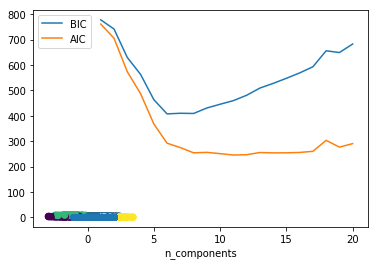

In [36]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)

# X = X[:, ::-1] #交换列是为了方便画图
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

probs = gmm.predict_proba(X)
print(probs[:5].round(3))

from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]


plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')